In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# from ema_workbench import (
#     Model,
#     Policy,
#     ema_logging,
#     SequentialEvaluator,
#     MultiprocessingEvaluator, 
#     perform_experiments,
#     Samplers, 
# )
# from SALib.analyze import sobol
# from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# from ema_workbench.analysis import (feature_scoring, pairs_plotting)
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
from ema_workbench import SequentialEvaluator

# from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
# from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome



In [2]:
# First, get the model
dike_model, planning_steps = get_model_for_problem_formulation(3)
print(dike_model)
print(planning_steps)

# We will need experiments and outcomes, for the sake of scoping they are listed here
experiments, outcomes = ...

[0 1 2]


In [38]:
# Optional: run the model a bunch of times and save it to a file, change boolean below if you want to run it or not
# False means: don't run it and use the presaved data
# True means: do run the program
want_to_run = False

if want_to_run:
    with SequentialEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=100, policies=30)
        
    # split the results into experiments and outcomes
    experiments, outcomes = results
    experiments.info()
    
    #save the results so that this (which takes like 2 hours) doesn't need to be rerun over and over
    with open('data from all the runs', 'wb') as file:
        pickle.dump(results, file)
    

[MainProcess/INFO] performing 100 scenarios * 30 policies * 1 model(s) = 3000 experiments
100%|████████████████████████████████████| 3000/3000 [1:25:43<00:00,  1.71s/it]
[MainProcess/INFO] experiments finished


In [51]:
if not want_to_run:
    # open the results so that you do prim on them
    with open('data from all the runs', 'rb') as file:
        loaded_data = pickle.load(file)
    experiments, outcomes = loaded_data
    print(outcomes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   A.0_ID flood wave shape  3000 non-null   int32   
 1   A.1_Bmax                 3000 non-null   float64 
 2   A.1_Brate                3000 non-null   category
 3   A.1_pfail                3000 non-null   float64 
 4   A.2_Bmax                 3000 non-null   float64 
 5   A.2_Brate                3000 non-null   category
 6   A.2_pfail                3000 non-null   float64 
 7   A.3_Bmax                 3000 non-null   float64 
 8   A.3_Brate                3000 non-null   category
 9   A.3_pfail                3000 non-null   float64 
 10  A.4_Bmax                 3000 non-null   float64 
 11  A.4_Brate                3000 non-null   category
 12  A.4_pfail                3000 non-null   float64 
 13  A.5_Bmax                 3000 non-null   float64 
 14  A.5_Brat

In [81]:
# Datacleaning
experiments.head()

# Remove irrelevant columns
experiments.drop(columns=['policy', 'scenario', 'model'], inplace = True)

In [82]:
df = pd.DataFrame(outcomes)

# Summing the total costs
df['Total Costs'] = df[['A.1 Total Costs', 'A.2 Total Costs', 'A.3 Total Costs', 
                        'A.4 Total Costs', 'A.5 Total Costs', 'RfR Total Costs', 
                        'Expected Evacuation Costs']].sum(axis=1)

# Summing the total expected number of deaths
df['Total Deaths'] = df[['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 
                         'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 
                         'A.5_Expected Number of Deaths']].sum(axis=1)


,Total Costs,Total Deaths
0,2.000412e+09,0.004508
1,1.997219e+09,0.000000
2,1.997219e+09,0.000000
3,1.997219e+09,0.000000
4,1.997219e+09,0.000000
...,...,...
2995,1.642503e+09,0.000056
2996,1.645938e+09,0.001627
2997,1.642420e+09,0.000000
2998,1.649383e+09,0.006598


In [118]:
#250 000 000 budget euro

# Define what policies are deemed unacceptable
df['Unacceptable'] = ( (df['Total Deaths'] > 0) & (df['Total Costs'] > 1000000000)).astype(int) 
# Turn these values into the y variable in the form of an array
y = df['Unacceptable'].values
print(y)
print(df['Unacceptable'].value_counts(1))

[1 0 0 ... 0 1 1]
1    0.746667
0    0.253333
Name: Unacceptable, dtype: float64


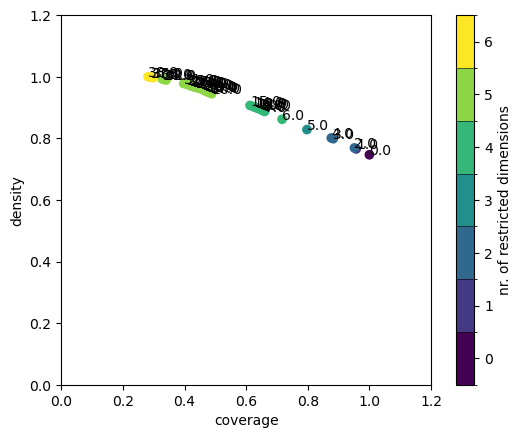

In [119]:
ema_logging.log_to_stderr(ema_logging.INFO)

#Perform prim
prim_alg = prim.Prim(experiments, y, threshold=0.7, peel_alpha=0.05)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()



In [123]:
# Pick a point
point = 5
box1.inspect(point)

coverage       0.797321
density        0.828386
id             5.000000
k           1786.000000
mass           0.718667
mean           0.828386
n           2156.000000
res_dim        3.000000
Name: 5, dtype: float64

                                                                box 5  \
                                                                  min   
A.3_DikeIncrease 0                                                0.0   
A.3_DikeIncrease 1                                                1.0   
num_events          {30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 4...   

                                                                       \
                                                                  max   
A.3_DikeIncrease 0                                                9.0   
A.3_DikeIncrease 1                                                9.0   
num_events          {30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 4...   

                                        
          

[None]

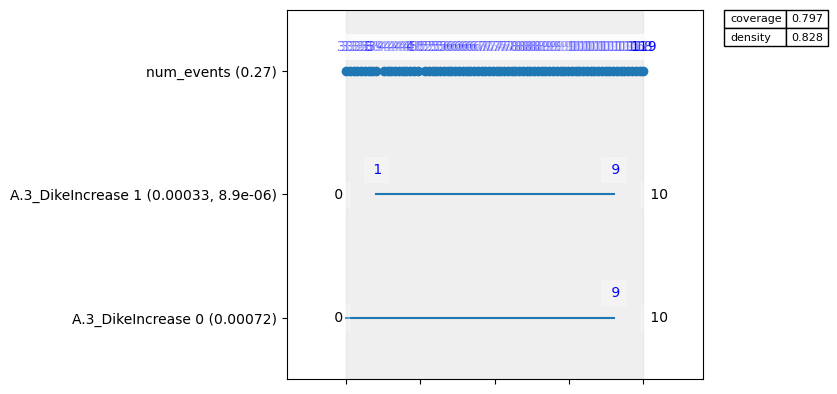

In [124]:
# Make the weird plot thing
box1.inspect(point, style='graph')
plt.show()

In [125]:
# See how reproducable it is
box1.resample(point)

,reproduce coverage,reproduce density
num_events,100.0,100.0
A.3_DikeIncrease 1,90.0,90.0
A.3_DikeIncrease 0,50.0,20.0
A.2_DikeIncrease 1,10.0,10.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.1_pfail,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0


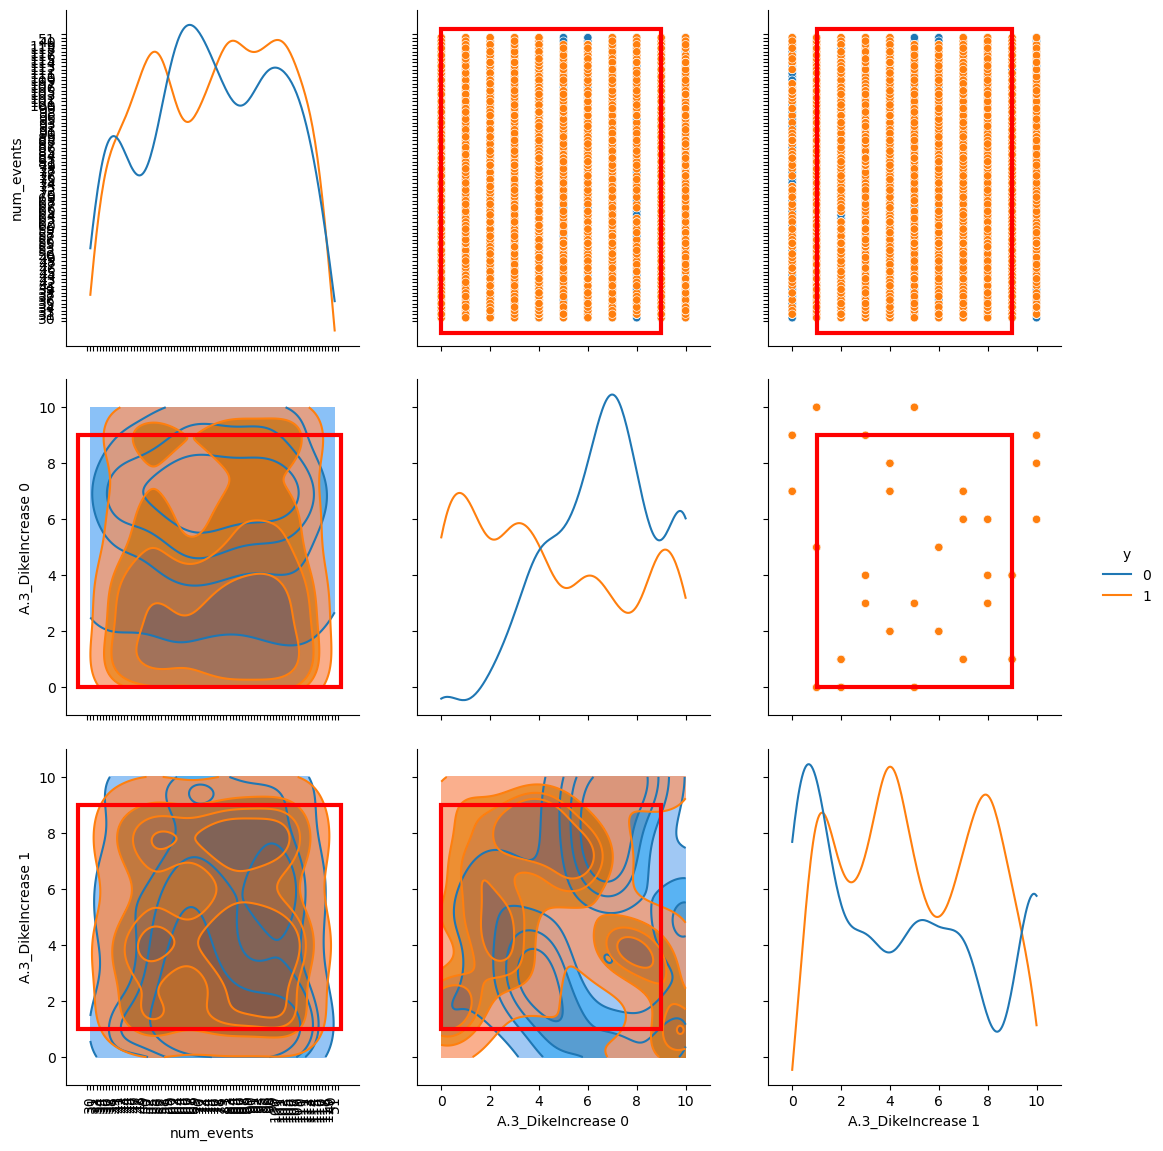

In [126]:
#Make pretty plots for the chosen point
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()